# VinBigData detectron2 train


This competition is object detaction task to find a class and location of thoracic abnormalities from chest x-ray image (radiographs).

`detectron2` is one of the famous pytorch object detection library, I will introduce how to use this library to train models provided by this library with this competition's data!

 - https://github.com/facebookresearch/detectron2

> Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark.
![](https://user-images.githubusercontent.com/1381301/66535560-d3422200-eace-11e9-9123-5535d469db19.png)


[UPDATE 2021/1/11] I published prediction kernel, please check https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction too!

[UPDATE 2021/1/24] I added more advanced usage to customize <code>detectron2</code>, especially:

 - How to define & use `mapper` to add your customized augmentation.
 - Use validation data during training.
 - Define `Evaluator` and calculating competition metric, AP40.
 - Define `Hook` to calculate validation loss & plotting training/validation loss curve.

<div style="color:red">
    [UPDATE 2021/2/18] Added links to relevant useful discussions in "Next step" topic.</div>

# Table of Contents

** [Dataset preparation](#dataset)** <br/>
** [Installation](#installation)** <br/>
** [Training method implementations](#train_method)** <br/>
** [Customizing detectron2 trainer](#custom_trainer) ** [Advanced topic, skip it first time] <br/>
**   - [Mapper for augmentation](#mapper)** <br/>
**   - [Evaluator](#evaluator)** <br/>
**   - [Loss evaluation hook](#loss_hook)** <br/>
** [Loading Data](#load_data)** <br/>
** [Data Visualization](#data_vis)** <br/>
** [Training](#training)** <br/>
** [Visualize loss curve & competition metric AP40](#vis_loss)** <br/>
** [Visualization of augmentation by Mapper](#vis_aug)** <br/>
** [Next step](#next_step)** <br/>

<a id="dataset"></a>
# Dataset preparation

Preprocessing x-ray image format (dicom) into normal png image format is already done by @xhlulu in the below discussion:
 - [Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207955).

Here I will just use the dataset [VinBigData Chest X-ray Resized PNG (256x256)](https://www.kaggle.com/xhlulu/vinbigdata-chest-xray-resized-png-256x256) to skip the preprocessing and focus on modeling part.

I also uploaded the original sized png images:
 - [vinbigdata-chest-xray-original-png](https://www.kaggle.com/corochann/vinbigdata-chest-xray-original-png) ([notebook](https://www.kaggle.com/corochann/preprocessing-image-original-size-lossless-png) on kaggle fails due to disk limit)

Please upvote the dataset as well!

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm #progress bar
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns #statistical data visualization

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)


<a id="installation"></a>
# Installation

detectron2 is not pre-installed in this kaggle docker, so let's install it. 
We can follow [installation instruction](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md), we need to know CUDA and pytorch version to install correct `detectron2`.

In [2]:
!nvidia-smi

Mon May 24 15:48:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX150       Off  | 00000000:02:00.0 Off |                  N/A |
| N/A   88C    P0    N/A /  N/A |    498MiB /  2002MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
import torch

torch.__version__

'1.7.1'

It seems CUDA=10.2 and torch==1.7.0 is used in this kaggle docker image.

See [installation](https://detectron2.readthedocs.io/tutorials/install.html) for details.

In [5]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


<a id="train_method"></a>
# Training method implementations

Basically we don't need to implement neural network part, `detectron2` already implements famous architectures and provides its pre-trained weights. We can finetune these pre-trained architectures.

These models are summarized in [MODEL_ZOO.md](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

In this competition, we need object detection model, I will choose [R50-FPN](https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml) for this kernel.

## Data preparation

`detectron2` provides high-level API for training custom dataset.

To define custom dataset, we need to create **list of dict** (`dataset_dicts`) where each dict contains following:

 - file_name: file name of the image.
 - image_id: id of the image, index is used here.
 - height: height of the image.
 - width: width of the image.
 - annotation: This is the ground truth annotation data for object detection, which contains following
     - bbox: bounding box pixel location with shape (n_boxes, 4)
     - bbox_mode: `BoxMode.XYXY_ABS` is used here, meaning that absolute value of (xmin, ymin, xmax, ymax) annotation is used in the `bbox`.
     - category_id: class label id for each bounding box, with shape (n_boxes,)

`get_vinbigdata_dicts` is for train dataset preparation and `get_vinbigdata_dicts_test` is for test dataset preparation.

This `dataset_dicts` contains the metadata for actual data fed into the neural network.<br/>
It is loaded beforehand of the training **on memory**, so it should contain all the metadata (image filepath etc) to construct training dataset, but **should not contain heavy data**.<br/>

In practice, loading all the taining image arrays are too heavy to be loaded on memory, so these are loaded inside `DataLoader` on-demand (This is done by mapper class in `detectron2`, as I will explain later).

In [6]:
import pickle # Python object serialization
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
    use_class14: bool = False,
):
    # name the dataset dictionary *.pkl file
    debug_str = f"_debug{int(debug)}" #formatted string: _debug1
    train_data_type_str = f"_{train_data_type}"
    class14_str = f"_14class{int(use_class14)}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{class14_str}{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug... select only 500 records

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):#iterate with estimated progress
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    if use_class14:
                        # Use this No finding class with the bbox covering all image area.
                        bbox_resized = [0, 0, resized_width, resized_height]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    else:
                        # This annotator does not find anything, skip.
                        pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        float(row["x_min"]) * w_ratio,
                        float(row["y_min"]) * h_ratio,
                        float(row["x_max"]) * w_ratio,
                        float(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


In [7]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content


In [8]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}


<a id="custom_trainer"></a>
# Customizing detectron2 trainer

※ This section is advanced, I recommend to jump to **Training scripts** section for the first time of reading.

You can refer the [Detectron2 Beginner's Tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=QHnVupBBn9eR) Colab Notebook (or [version 7 of this kernel](https://www.kaggle.com/corochann/vinbigdata-detectron2-train?scriptVersionId=51628272)) for the simple usage of detectron2 how to train custom dataset. `DefaultTrainer` is used in the example which provides the starting point to train your model with custom dataset.

It is nice to start with, however I want to customize the training behavior more to improve the model's performance.
We can make own Trainer class (`MyTrainer` here) for this purpose, and override methods to provide customized behavior.

<a id="mapper"></a>
## Mapper for augmentation

`Mapper` class is used inside pytorch `DataLoader`. It is responsible for converting `dataset_dicts` into actual data fed into the neural network, and we can insert augmentation process in this Mapper class.

 - Ref: [detectron2 docs "Dataloader"](https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html)

I implemented `MyMapper` which uses augmentations implemented in `detectron2`, and `AlbumentationsMapper` which uses albumentations library augmentations.<br/> 
I will demonstrate these augmentations later, so you can skip reading the code and please just jump to next.

In [9]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""
import copy
import logging

import detectron2.data.transforms as T
import torch
from detectron2.data import detection_utils as utils


class MyMapper:
    """Mapper which uses `detectron2.data.transforms` augmentations"""

    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
            # T.Resize((800, 800)),
        ]
        if is_train:
            aug_list.extend([getattr(T, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.augmentations = T.AugmentationList(aug_list)
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[MyDatasetMapper] Augmentations used in {mode}: {self.augmentations}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        aug_input = T.AugInput(image)
        transforms = self.augmentations(aug_input)
        image = aug_input.image

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        annos = [
            utils.transform_instance_annotations(obj, transforms, image_shape)
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [10]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""
import albumentations as A
import copy
import numpy as np

import torch
from detectron2.data import detection_utils as utils


class AlbumentationsMapper:
    """Mapper which uses `albumentations` augmentations"""
    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
        ]
        if is_train:
            aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.transform = A.Compose(
            aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"])
        )
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        # aug_input = T.AugInput(image)
        # transforms = self.augmentations(aug_input)
        # image = aug_input.image

        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        # category_id = np.array([obj["category_id"] for obj in dataset_dict["annotations"]], dtype=np.int64)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
        image = transformed["image"]
        annos = []
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
        dataset_dict.pop("annotations", None)  # Remove unnecessary field.

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict


<a id="evaluator"></a>
## Evaluator

To evaluate validation dataset to calculate competition metric, we need `Evaluator`.

Famouns dataset's evaluator is already implemented in `detectron2`. <br/>
For example, many kinds of AP (Average Precision) is calculted in `COCOEvaluator`.<br/>
`COCOEvaluator` only calculates AP with IoU from 0.50 to 0.95, but we need AP with IoU 0.40.

Here, I modified `COCOEvaluator` implementation to calculate AP with IoU 0.40 and replaced to show this value instead of AP with IoU 0.70.

In [11]:
"""
Original code from https://github.com/cocodataset/cocoapi/blob/8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9/PythonAPI/pycocotools/cocoeval.py
Just modified to show AP@40
"""
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table


def vin_summarize(self):
    '''
    Compute and display summary metrics for evaluation results.
    Note this functin can *only* be applied on the default parameter setting
    '''

    def _summarize(ap=1, iouThr=None, areaRng='all', maxDets=100):
        p = self.params
        iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
        titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
        typeStr = '(AP)' if ap == 1 else '(AR)'
        iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
            if iouThr is None else '{:0.2f}'.format(iouThr)

        aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
        mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
        if ap == 1:
            # dimension of precision: [TxRxKxAxM]
            s = self.eval['precision']
            # IoU
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, :, aind, mind]
        else:
            # dimension of recall: [TxKxAxM]
            s = self.eval['recall']
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, aind, mind]
        if len(s[s > -1]) == 0:
            mean_s = -1
        else:
            mean_s = np.mean(s[s > -1])
        print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
        return mean_s

    def _summarizeDets():
        stats = np.zeros((12,))
        stats[0] = _summarize(1)
        stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
        # stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
        stats[2] = _summarize(1, iouThr=.4, maxDets=self.params.maxDets[2])
        stats[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
        stats[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
        stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
        stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
        stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
        stats[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
        stats[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
        return stats

    def _summarizeKps():
        stats = np.zeros((10,))
        stats[0] = _summarize(1, maxDets=20)
        stats[1] = _summarize(1, maxDets=20, iouThr=.5)
        stats[2] = _summarize(1, maxDets=20, iouThr=.75)
        stats[3] = _summarize(1, maxDets=20, areaRng='medium')
        stats[4] = _summarize(1, maxDets=20, areaRng='large')
        stats[5] = _summarize(0, maxDets=20)
        stats[6] = _summarize(0, maxDets=20, iouThr=.5)
        stats[7] = _summarize(0, maxDets=20, iouThr=.75)
        stats[8] = _summarize(0, maxDets=20, areaRng='medium')
        stats[9] = _summarize(0, maxDets=20, areaRng='large')
        return stats

    if not self.eval:
        raise Exception('Please run accumulate() first')
    iouType = self.params.iouType
    if iouType == 'segm' or iouType == 'bbox':
        summarize = _summarizeDets
    elif iouType == 'keypoints':
        summarize = _summarizeKps
    self.stats = summarize()


print("HACKING: overriding COCOeval.summarize = vin_summarize...")
COCOeval.summarize = vin_summarize


class VinbigdataEvaluator(DatasetEvaluator):
    """
    Evaluate AR for object proposals, AP for instance detection/segmentation, AP
    for keypoint detection outputs using COCO's metrics.
    See http://cocodataset.org/#detection-eval and
    http://cocodataset.org/#keypoints-eval to understand its metrics.

    In addition to COCO, this evaluator is able to support any bounding box detection,
    instance segmentation, or keypoint detection dataset.
    """

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        use_fast_impl=True,
        kpt_oks_sigmas=(),
    ):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:

                    "json_file": the path to the COCO format annotation

                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            tasks (tuple[str]): tasks that can be evaluated under the given
                configuration. A task is one of "bbox", "segm", "keypoints".
                By default, will infer this automatically from predictions.
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will only evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:

                1. "instances_predictions.pth" a file in torch serialization
                   format that contains all the raw original predictions.
                2. "coco_instances_results.json" a json file in COCO's result
                   format.
            use_fast_impl (bool): use a fast but **unofficial** implementation to compute AP.
                Although the results should be very close to the official implementation in COCO
                API, it is still recommended to compute results with the official API for use in
                papers. The faster implementation also uses more RAM.
            kpt_oks_sigmas (list[float]): The sigmas used to calculate keypoint OKS.
                See http://cocodataset.org/#keypoints-eval
                When empty, it will use the defaults in COCO.
                Otherwise it should be the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
        """
        self._logger = logging.getLogger(__name__)
        self._distributed = distributed
        self._output_dir = output_dir
        self._use_fast_impl = use_fast_impl

        if tasks is not None and isinstance(tasks, CfgNode):
            kpt_oks_sigmas = (
                tasks.TEST.KEYPOINT_OKS_SIGMAS if not kpt_oks_sigmas else kpt_oks_sigmas
            )
            self._logger.warn(
                "COCO Evaluator instantiated using config, this is deprecated behavior."
                " Please pass in explicit arguments instead."
            )
            self._tasks = None  # Infering it from predictions should be better
        else:
            self._tasks = tasks

        self._cpu_device = torch.device("cpu")

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            self._logger.info(
                f"'{dataset_name}' is not registered by `register_coco_instances`."
                " Therefore trying to convert it to COCO format ..."
            )

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset
        if self._do_evaluation:
            self._kpt_oks_sigmas = kpt_oks_sigmas

    def reset(self):
        self._predictions = []

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                self._predictions.append(prediction)

    def evaluate(self, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[VinbigdataEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _tasks_from_predictions(self, predictions):
        """
        Get COCO API "tasks" (i.e. iou_type) from COCO-format predictions.
        """
        tasks = {"bbox"}
        for pred in predictions:
            if "segmentation" in pred:
                tasks.add("segm")
            if "keypoints" in pred:
                tasks.add("keypoints")
        return sorted(tasks)

    def _eval_predictions(self, predictions, img_ids=None):
        """
        Evaluate predictions. Fill self._results with the metrics of the tasks.
        """
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas=self._kpt_oks_sigmas,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.

        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0 ** 2, 1e5 ** 2],  # all
        [0 ** 2, 32 ** 2],  # small
        [32 ** 2, 96 ** 2],  # medium
        [96 ** 2, 1e5 ** 2],  # large
        [96 ** 2, 128 ** 2],  # 96-128
        [128 ** 2, 256 ** 2],  # 128-256
        [256 ** 2, 512 ** 2],  # 256-512
        [512 ** 2, 1e5 ** 2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        # thresholds = torch.arange(0.5, 0.95 + 1e-5, step, dtype=torch.float32)
        thresholds = torch.arange(0.4, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)
    # ar = 2 * np.trapz(recalls, thresholds)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(
    coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True, img_ids=None
):
    """
    Evaluate the coco results using COCOEval API.
    """
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = (COCOeval_opt if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)

    # HACKING: overwrite iouThrs to calc ious 0.4
    coco_eval.params.iouThrs = np.linspace(
        .4, 0.95, int(np.round((0.95 - .4) / .05)) + 1, endpoint=True)

    if img_ids is not None:
        coco_eval.params.imgIds = img_ids

    if iou_type == "keypoints":
        # Use the COCO default keypoint OKS sigmas unless overrides are specified
        if kpt_oks_sigmas:
            assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
            coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
        # COCOAPI requires every detection and every gt to have keypoints, so
        # we just take the first entry from both
        num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
        num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
        num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
        assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
            f"[VinbigdataEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
            f"Ground truth contains {num_keypoints_gt} keypoints. "
            f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
            "They have to agree with each other. For meaning of OKS, please refer to "
            "http://cocodataset.org/#keypoints-eval."
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval


HACKING: overriding COCOeval.summarize = vin_summarize...


<a id="loss_hook"></a>
## Loss evaluation hook

We implemented Evaluator and now we can calculate competition metric, however, validation loss is not calculated inside Evaluator. This is because model's evaluation is done in `model.eval()` mode and it outputs bounding box prediction but does not output `loss`.

To calculate validation loss, we need to call `model` with the training mode. This can be done by adding `Hook` which calculates the loss to the trainer.<br/>
Trainer has attribute `storage` and calculated metrics are summarized. Its content is saved to `metric.json` (jsonl format) during training.

Below `LossEvalHook` calculates validation loss in `_do_loss_eval` method, and `self.trainer.storage.put_scalars(validation_loss=mean_loss)` is called to put this validation loss to the `storage`, which will be saved to `metrics.json`.<br/>
Note that current implementation is not efficient in the sense that Evaluator's evaluation and `LossEvalHook`'s loss calculation run separately, even if both need a model forward calculation for same validation data.

 - Ref: [Training on Detectron2 with a Validation set, and plot loss on it to avoid overfitting](https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e)

In [12]:
"""
To calculate & record validation loss

Original code from https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
by @apofeniaco
"""
import numpy as np
import logging

from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
import torch
import time
import datetime


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        # self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        # return losses
        return mean_loss

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = int(self.trainer.iter) + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)
        else:
            pass
            # self.trainer.storage.put_scalars(timetest=11)


Now all the preparation has done!

`MyTrainer` overwraps `build_evaluator` method of `DefaultTrainer` provided by `detectron2` to support validation dataset evaluation.


1. `build_train_loader` & `build_test_loader`: 
These class methods deine how to construct DataLoader for training data & validation data respectively.
Here `AlbumentationMapper` is passed to construct DataLoader to insert customized augmentation process.

2. `build_evaluator`:
This class method defines how to construct Evaluator. 
Here implemented `VinbigdataEvaluator` is constructed (we can also use `COCOEvaluator` here).

3. `build_hooks`:
This method defines how to construct hooks. I insert `LossEvalHook` before evalutor to work well.

In [13]:
import os

from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch

# from detectron2.evaluation import COCOEvaluator, PascalVOCDetectionEvaluator


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(cfg, False)
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        # return PascalVOCDetectionEvaluator(dataset_name)  # not working
        # return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)
        return VinbigdataEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)

    def build_hooks(self):
        hooks = super(MyTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MyTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)

        return hooks


## LR scheduling

To further customize learning rate scheduling you may override `build_lr_scheduler` class method to construct any pytorch LRScheduler.

Default `build_lr_schduler` method ([docs](https://detectron2.readthedocs.io/en/latest/_modules/detectron2/solver/build.html#build_lr_scheduler)) supports only 2 types of LR scheduling, WarmupMultiStepLR (default) & WarmupCosineLR. You can change which one to use by setting `cfg.SOLVER.LR_SCHEDULER_NAME` as you can see from the docs.

Now the methods are ready. main scripts starts from here.

<a id="load_data"></a>
# Loading Data

This `Flags` class is to manage experiments. I will tune these parameters through the competition to improve model's performance.

In [14]:
import argparse
import dataclasses
import json
import os
import pickle
import random
import sys
from dataclasses import dataclass
from distutils.util import strtobool
from pathlib import Path

import cv2
import detectron2
import numpy as np
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm

setup_logger()

<Logger detectron2 (DEBUG)>

In [15]:
# --- flags ---
from dataclasses import dataclass, field
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"

    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    train_data_type: str = "original"  # original or wbf
    use_class14: bool = False
    # Training config
    iter: int = 10000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    lr_scheduler_name: str = "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [16]:
# flags_dict = {
#     "debug": True,
#     "outdir": "results/debug", 
#     "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256",
#     "split_mode": "valid20",
#     "iter": 100,  # debug, small value should be set.
#     "roi_batch_size_per_image": 128,  # faster, and good enough for this toy dataset (default: 512)
#     "eval_period": 20,
#     "aug_kwargs": {
#         "HorizontalFlip": {"p": 0.5},
#         "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
#         "RandomBrightnessContrast": {"p": 0.5}
#     }
# }

In [17]:
flags_dict = {
    "debug": False,
    "outdir": "results/v9", 
    "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256",
    "split_mode": "valid20",
    "iter": 10000,
    "roi_batch_size_per_image": 512,
    "eval_period": 1000,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "num_workers": 4,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5}
    }
}

In [19]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

# --- Read data ---
inputdir = Path("../..")
datadir = inputdir / "vinbigdata-chest-xray-abnormalities-detection"
imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
train_df = pd.read_csv(datadir / "train.csv")
train = train_df  # alias
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

torch 1.7.1
flags Flags(debug=False, outdir='results/v9', imgdir_name='vinbigdata-chest-xray-resized-png-256x256', split_mode='valid20', seed=111, train_data_type='original', use_class14=False, iter=10000, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.001, roi_batch_size_per_image=512, eval_period=1000, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}})


In [21]:
train_data_type = flags.train_data_type
if flags.use_class14:
    thing_classes.append("No finding")

split_mode = flags.split_mode
if split_mode == "all_train":
    DatasetCatalog.register(
        "vinbigdata_train",
        lambda: get_vinbigdata_dicts(
            imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
        ),
    )
    MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
elif split_mode == "valid20":
    # To get number of data...
    n_dataset = len(
        get_vinbigdata_dicts(
            imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
        )
    )
    n_train = int(n_dataset * 0.8)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(flags.seed)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        "vinbigdata_train",
        lambda: get_vinbigdata_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=train_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
    DatasetCatalog.register(
        "vinbigdata_valid",
        lambda: get_vinbigdata_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=valid_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("vinbigdata_valid").set(thing_classes=thing_classes)
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")


  0%|          | 24/15000 [00:00<01:03, 235.19it/s]

Creating data...
image shape: (256, 256, 3)


100%|██████████| 15000/15000 [01:45<00:00, 142.03it/s]


Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
n_dataset 15000 n_train 12000


In [22]:
dataset_dicts = get_vinbigdata_dicts(imgdir, train, debug=debug)

Load from cache dataset_dicts_cache_original_14class0_debug0.pkl


<a id="data_vis"></a>
# Data Visualization

It's also very easy to visualize prepared training dataset with `detectron2`.<br/>
It provides `Visualizer` class, we can use it to draw an image with bounding box as following.

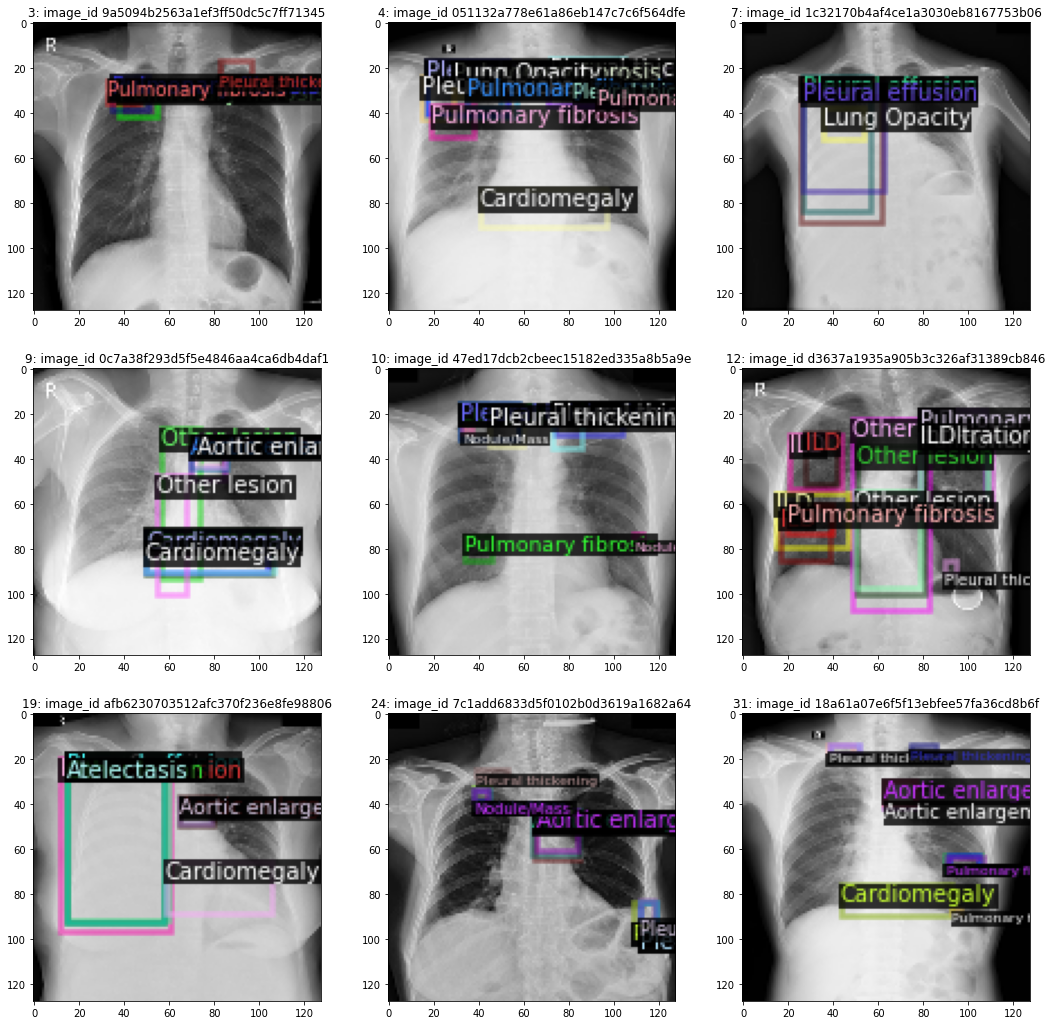

In [23]:
# Visualize data...
anomaly_image_ids = train.query("class_id != 14")["image_id"].unique()
train_meta = pd.read_csv(imgdir/"train_meta.csv")
anomaly_inds = np.argwhere(train_meta["image_id"].isin(anomaly_image_ids).values)[:, 0]

vinbigdata_metadata = MetadataCatalog.get("vinbigdata_train")

cols = 3
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
axes = axes.flatten()

for index, anom_ind in enumerate(anomaly_inds[:cols * rows]):
    ax = axes[index]
    # print(anom_ind)
    d = dataset_dicts[anom_ind]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vinbigdata_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # cv2_imshow(out.get_image()[:, :, ::-1])
    #cv2.imwrite(str(outdir / f"vinbigdata{index}.jpg"), out.get_image()[:, :, ::-1])
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.set_title(f"{anom_ind}: image_id {anomaly_image_ids[index]}")

<a id="training"></a>
# Training

In [24]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = ("vinbigdata_valid",)
    cfg.TEST.EVAL_PERIOD = flags.eval_period

cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


cfg.OUTPUT_DIR ./output -> results/v9


In [25]:
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/24 15:57:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
[05/24 15:57:24 d2.data.build]: Removed 8505 images with no usable annotations. 3495 images left.
[05/24 15:57:24 d2.data.build]: Distribution of instances among all 14 categories:
|   category    | #instances   |   category    | #instan

model_final_280758.pkl: 167MB [00:17, 9.41MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.


[05/24 15:57:46 d2.engine.train_loop]: Starting training from iteration 0


/home/weronika/.local/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



[05/24 15:57:58 d2.utils.events]:  eta: 1:43:50  iter: 19  total_loss: 4.88  loss_cls: 2.603  loss_box_reg: 0.01839  loss_rpn_cls: 2.018  loss_rpn_loc: 0.225  time: 0.6171  data_time: 0.0105  lr: 1.9516e-05  max_mem: 739M
[05/24 15:58:11 d2.utils.events]:  eta: 1:45:11  iter: 39  total_loss: 2.82  loss_cls: 1.674  loss_box_reg: 0.09796  loss_rpn_cls: 0.6653  loss_rpn_loc: 0.1308  time: 0.6231  data_time: 0.0064  lr: 3.9007e-05  max_mem: 739M
[05/24 15:58:22 d2.utils.events]:  eta: 1:36:28  iter: 59  total_loss: 1.206  loss_cls: 0.4667  loss_box_reg: 0.07553  loss_rpn_cls: 0.5227  loss_rpn_loc: 0.1274  time: 0.6028  data_time: 0.0040  lr: 5.8497e-05  max_mem: 739M
[05/24 15:58:35 d2.utils.events]:  eta: 1:37:48  iter: 79  total_loss: 0.9372  loss_cls: 0.291  loss_box_reg: 0.1028  loss_rpn_cls: 0.36  loss_rpn_loc: 0.1364  time: 0.6045  data_time: 0.0055  lr: 7.7988e-05  max_mem: 739M
[05/24 15:58:46 d2.utils.events]:  eta: 1:37:14  iter: 99  total_loss: 0.7794  loss_cls: 0.2814  loss_box

[05/24 16:04:35 d2.utils.events]:  eta: 1:24:47  iter: 719  total_loss: 0.6955  loss_cls: 0.2395  loss_box_reg: 0.1871  loss_rpn_cls: 0.1598  loss_rpn_loc: 0.0913  time: 0.5664  data_time: 0.0045  lr: 0.00070169  max_mem: 739M
[05/24 16:04:46 d2.utils.events]:  eta: 1:24:37  iter: 739  total_loss: 0.5601  loss_cls: 0.1589  loss_box_reg: 0.1468  loss_rpn_cls: 0.1774  loss_rpn_loc: 0.08045  time: 0.5662  data_time: 0.0050  lr: 0.00072118  max_mem: 739M
[05/24 16:04:57 d2.utils.events]:  eta: 1:24:28  iter: 759  total_loss: 0.9167  loss_cls: 0.2424  loss_box_reg: 0.1834  loss_rpn_cls: 0.2859  loss_rpn_loc: 0.1953  time: 0.5659  data_time: 0.0044  lr: 0.00074067  max_mem: 739M
[05/24 16:05:08 d2.utils.events]:  eta: 1:24:14  iter: 779  total_loss: 0.6112  loss_cls: 0.1434  loss_box_reg: 0.123  loss_rpn_cls: 0.2151  loss_rpn_loc: 0.08972  time: 0.5653  data_time: 0.0043  lr: 0.00076016  max_mem: 739M
[05/24 16:05:19 d2.utils.events]:  eta: 1:24:05  iter: 799  total_loss: 0.9597  loss_cls: 0

[05/24 16:10:26 d2.evaluation.evaluator]: Inference done 1308/3000. 0.1434 s / img. ETA=0:04:05
[05/24 16:10:31 d2.evaluation.evaluator]: Inference done 1341/3000. 0.1436 s / img. ETA=0:04:01
[05/24 16:10:36 d2.evaluation.evaluator]: Inference done 1374/3000. 0.1437 s / img. ETA=0:03:56
[05/24 16:10:42 d2.evaluation.evaluator]: Inference done 1409/3000. 0.1437 s / img. ETA=0:03:51
[05/24 16:10:47 d2.evaluation.evaluator]: Inference done 1446/3000. 0.1434 s / img. ETA=0:03:45
[05/24 16:10:52 d2.evaluation.evaluator]: Inference done 1483/3000. 0.1432 s / img. ETA=0:03:40
[05/24 16:10:57 d2.evaluation.evaluator]: Inference done 1520/3000. 0.1430 s / img. ETA=0:03:34
[05/24 16:11:02 d2.evaluation.evaluator]: Inference done 1558/3000. 0.1427 s / img. ETA=0:03:28
[05/24 16:11:07 d2.evaluation.evaluator]: Inference done 1596/3000. 0.1425 s / img. ETA=0:03:22
[05/24 16:11:12 d2.evaluation.evaluator]: Inference done 1634/3000. 0.1422 s / img. ETA=0:03:16
[05/24 16:11:17 d2.evaluation.evaluator]

[05/24 16:15:30 detectron2]: Loss on Validation  done 461/3000. 0.0001 s / img. ETA=0:05:14
[05/24 16:15:35 detectron2]: Loss on Validation  done 495/3000. 0.0001 s / img. ETA=0:05:14
[05/24 16:15:40 detectron2]: Loss on Validation  done 527/3000. 0.0001 s / img. ETA=0:05:15
[05/24 16:15:45 detectron2]: Loss on Validation  done 565/3000. 0.0001 s / img. ETA=0:05:11
[05/24 16:15:50 detectron2]: Loss on Validation  done 607/3000. 0.0001 s / img. ETA=0:05:05
[05/24 16:15:55 detectron2]: Loss on Validation  done 643/3000. 0.0001 s / img. ETA=0:05:02
[05/24 16:16:00 detectron2]: Loss on Validation  done 682/3000. 0.0001 s / img. ETA=0:04:57
[05/24 16:16:05 detectron2]: Loss on Validation  done 716/3000. 0.0001 s / img. ETA=0:04:55
[05/24 16:16:10 detectron2]: Loss on Validation  done 756/3000. 0.0001 s / img. ETA=0:04:50
[05/24 16:16:16 detectron2]: Loss on Validation  done 794/3000. 0.0001 s / img. ETA=0:04:45
[05/24 16:16:21 detectron2]: Loss on Validation  done 832/3000. 0.0001 s / img. 

[05/24 16:22:12 d2.utils.events]:  eta: 1:21:39  iter: 1119  total_loss: 0.6977  loss_cls: 0.1642  loss_box_reg: 0.1701  loss_rpn_cls: 0.173  loss_rpn_loc: 0.07806  validation_loss: 0.3966  time: 0.5726  data_time: 0.0086  lr: 0.00096942  max_mem: 739M
[05/24 16:22:25 d2.utils.events]:  eta: 1:21:31  iter: 1139  total_loss: 0.7495  loss_cls: 0.2247  loss_box_reg: 0.2143  loss_rpn_cls: 0.2055  loss_rpn_loc: 0.1377  validation_loss: 0.3966  time: 0.5742  data_time: 0.0092  lr: 0.00096833  max_mem: 739M
[05/24 16:22:38 d2.utils.events]:  eta: 1:21:27  iter: 1159  total_loss: 0.7468  loss_cls: 0.1879  loss_box_reg: 0.1706  loss_rpn_cls: 0.2092  loss_rpn_loc: 0.1636  validation_loss: 0.3966  time: 0.5751  data_time: 0.0105  lr: 0.00096722  max_mem: 739M
[05/24 16:22:50 d2.utils.events]:  eta: 1:21:20  iter: 1179  total_loss: 0.8449  loss_cls: 0.2166  loss_box_reg: 0.2007  loss_rpn_cls: 0.2141  loss_rpn_loc: 0.1282  validation_loss: 0.3966  time: 0.5757  data_time: 0.0084  lr: 0.00096609  ma

[05/24 16:28:34 d2.utils.events]:  eta: 1:18:15  iter: 1759  total_loss: 0.8584  loss_cls: 0.2595  loss_box_reg: 0.2155  loss_rpn_cls: 0.2173  loss_rpn_loc: 0.08154  validation_loss: 0.3966  time: 0.5811  data_time: 0.0067  lr: 0.00092558  max_mem: 739M
[05/24 16:28:45 d2.utils.events]:  eta: 1:18:04  iter: 1779  total_loss: 0.8313  loss_cls: 0.2042  loss_box_reg: 0.2263  loss_rpn_cls: 0.1554  loss_rpn_loc: 0.2422  validation_loss: 0.3966  time: 0.5807  data_time: 0.0057  lr: 0.00092392  max_mem: 739M
[05/24 16:28:57 d2.utils.events]:  eta: 1:17:53  iter: 1799  total_loss: 0.5864  loss_cls: 0.1852  loss_box_reg: 0.193  loss_rpn_cls: 0.1308  loss_rpn_loc: 0.07434  validation_loss: 0.3966  time: 0.5804  data_time: 0.0061  lr: 0.00092225  max_mem: 739M
[05/24 16:29:09 d2.utils.events]:  eta: 1:17:49  iter: 1819  total_loss: 0.6462  loss_cls: 0.1635  loss_box_reg: 0.1807  loss_rpn_cls: 0.1465  loss_rpn_loc: 0.07638  validation_loss: 0.3966  time: 0.5807  data_time: 0.0085  lr: 0.00092056  

[05/24 16:34:38 d2.evaluation.evaluator]: Inference done 1512/3000. 0.1412 s / img. ETA=0:03:36
[05/24 16:34:43 d2.evaluation.evaluator]: Inference done 1547/3000. 0.1412 s / img. ETA=0:03:31
[05/24 16:34:48 d2.evaluation.evaluator]: Inference done 1580/3000. 0.1413 s / img. ETA=0:03:26
[05/24 16:34:53 d2.evaluation.evaluator]: Inference done 1612/3000. 0.1416 s / img. ETA=0:03:22
[05/24 16:34:58 d2.evaluation.evaluator]: Inference done 1647/3000. 0.1416 s / img. ETA=0:03:17
[05/24 16:35:03 d2.evaluation.evaluator]: Inference done 1682/3000. 0.1416 s / img. ETA=0:03:12
[05/24 16:35:08 d2.evaluation.evaluator]: Inference done 1713/3000. 0.1419 s / img. ETA=0:03:08
[05/24 16:35:14 d2.evaluation.evaluator]: Inference done 1742/3000. 0.1425 s / img. ETA=0:03:04
[05/24 16:35:19 d2.evaluation.evaluator]: Inference done 1772/3000. 0.1428 s / img. ETA=0:03:00
[05/24 16:35:24 d2.evaluation.evaluator]: Inference done 1803/3000. 0.1431 s / img. ETA=0:02:56
[05/24 16:35:29 d2.evaluation.evaluator]

[05/24 16:39:41 detectron2]: Loss on Validation  done 712/3000. 0.0001 s / img. ETA=0:04:07
[05/24 16:39:46 detectron2]: Loss on Validation  done 759/3000. 0.0001 s / img. ETA=0:04:01
[05/24 16:39:51 detectron2]: Loss on Validation  done 806/3000. 0.0001 s / img. ETA=0:03:56
[05/24 16:39:56 detectron2]: Loss on Validation  done 851/3000. 0.0001 s / img. ETA=0:03:52
[05/24 16:40:01 detectron2]: Loss on Validation  done 895/3000. 0.0001 s / img. ETA=0:03:48
[05/24 16:40:06 detectron2]: Loss on Validation  done 941/3000. 0.0001 s / img. ETA=0:03:43
[05/24 16:40:11 detectron2]: Loss on Validation  done 987/3000. 0.0001 s / img. ETA=0:03:38
[05/24 16:40:16 detectron2]: Loss on Validation  done 1033/3000. 0.0001 s / img. ETA=0:03:33
[05/24 16:40:21 detectron2]: Loss on Validation  done 1079/3000. 0.0001 s / img. ETA=0:03:28
[05/24 16:40:26 detectron2]: Loss on Validation  done 1125/3000. 0.0001 s / img. ETA=0:03:23
[05/24 16:40:31 detectron2]: Loss on Validation  done 1170/3000. 0.0001 s / i

[05/24 16:46:04 d2.utils.events]:  eta: 1:12:48  iter: 2219  total_loss: 0.9085  loss_cls: 0.252  loss_box_reg: 0.2666  loss_rpn_cls: 0.1413  loss_rpn_loc: 0.1332  validation_loss: 0.3554  time: 0.5794  data_time: 0.0059  lr: 0.00088335  max_mem: 739M
[05/24 16:46:15 d2.utils.events]:  eta: 1:12:25  iter: 2239  total_loss: 0.5884  loss_cls: 0.1675  loss_box_reg: 0.1745  loss_rpn_cls: 0.1229  loss_rpn_loc: 0.04109  validation_loss: 0.3554  time: 0.5791  data_time: 0.0056  lr: 0.00088132  max_mem: 739M
[05/24 16:46:26 d2.utils.events]:  eta: 1:12:05  iter: 2259  total_loss: 0.7527  loss_cls: 0.2141  loss_box_reg: 0.2257  loss_rpn_cls: 0.1717  loss_rpn_loc: 0.118  validation_loss: 0.3554  time: 0.5789  data_time: 0.0058  lr: 0.00087928  max_mem: 739M
[05/24 16:46:37 d2.utils.events]:  eta: 1:11:47  iter: 2279  total_loss: 0.6396  loss_cls: 0.225  loss_box_reg: 0.2157  loss_rpn_cls: 0.1353  loss_rpn_loc: 0.106  validation_loss: 0.3554  time: 0.5787  data_time: 0.0061  lr: 0.00087723  max_m

[05/24 16:52:17 d2.utils.events]:  eta: 1:06:27  iter: 2859  total_loss: 0.66  loss_cls: 0.1786  loss_box_reg: 0.1853  loss_rpn_cls: 0.1174  loss_rpn_loc: 0.0853  validation_loss: 0.3554  time: 0.5799  data_time: 0.0062  lr: 0.00081152  max_mem: 739M
[05/24 16:52:29 d2.utils.events]:  eta: 1:06:20  iter: 2879  total_loss: 0.6722  loss_cls: 0.2073  loss_box_reg: 0.165  loss_rpn_cls: 0.1642  loss_rpn_loc: 0.1255  validation_loss: 0.3554  time: 0.5800  data_time: 0.0074  lr: 0.00080905  max_mem: 739M
[05/24 16:52:41 d2.utils.events]:  eta: 1:06:09  iter: 2899  total_loss: 0.5866  loss_cls: 0.1531  loss_box_reg: 0.1537  loss_rpn_cls: 0.147  loss_rpn_loc: 0.06573  validation_loss: 0.3554  time: 0.5801  data_time: 0.0087  lr: 0.00080658  max_mem: 739M
[05/24 16:52:53 d2.utils.events]:  eta: 1:05:56  iter: 2919  total_loss: 0.6521  loss_cls: 0.2062  loss_box_reg: 0.1762  loss_rpn_cls: 0.1318  loss_rpn_loc: 0.1113  validation_loss: 0.3554  time: 0.5803  data_time: 0.0076  lr: 0.00080409  max_m

[05/24 16:58:27 d2.evaluation.evaluator]: Inference done 1891/3000. 0.1481 s / img. ETA=0:02:47
[05/24 16:58:32 d2.evaluation.evaluator]: Inference done 1926/3000. 0.1480 s / img. ETA=0:02:42
[05/24 16:58:37 d2.evaluation.evaluator]: Inference done 1961/3000. 0.1479 s / img. ETA=0:02:36
[05/24 16:58:43 d2.evaluation.evaluator]: Inference done 1996/3000. 0.1478 s / img. ETA=0:02:31
[05/24 16:58:48 d2.evaluation.evaluator]: Inference done 2032/3000. 0.1476 s / img. ETA=0:02:25
[05/24 16:58:53 d2.evaluation.evaluator]: Inference done 2067/3000. 0.1475 s / img. ETA=0:02:20
[05/24 16:58:58 d2.evaluation.evaluator]: Inference done 2103/3000. 0.1474 s / img. ETA=0:02:14
[05/24 16:59:03 d2.evaluation.evaluator]: Inference done 2139/3000. 0.1472 s / img. ETA=0:02:09
[05/24 16:59:08 d2.evaluation.evaluator]: Inference done 2174/3000. 0.1471 s / img. ETA=0:02:03
[05/24 16:59:13 d2.evaluation.evaluator]: Inference done 2210/3000. 0.1470 s / img. ETA=0:01:58
[05/24 16:59:18 d2.evaluation.evaluator]

[05/24 17:03:34 detectron2]: Loss on Validation  done 1295/3000. 0.0001 s / img. ETA=0:03:07
[05/24 17:03:39 detectron2]: Loss on Validation  done 1341/3000. 0.0001 s / img. ETA=0:03:02
[05/24 17:03:44 detectron2]: Loss on Validation  done 1387/3000. 0.0001 s / img. ETA=0:02:57
[05/24 17:03:49 detectron2]: Loss on Validation  done 1433/3000. 0.0001 s / img. ETA=0:02:52
[05/24 17:03:54 detectron2]: Loss on Validation  done 1479/3000. 0.0001 s / img. ETA=0:02:47
[05/24 17:03:59 detectron2]: Loss on Validation  done 1526/3000. 0.0001 s / img. ETA=0:02:41
[05/24 17:04:04 detectron2]: Loss on Validation  done 1573/3000. 0.0001 s / img. ETA=0:02:36
[05/24 17:04:09 detectron2]: Loss on Validation  done 1619/3000. 0.0001 s / img. ETA=0:02:31
[05/24 17:04:14 detectron2]: Loss on Validation  done 1666/3000. 0.0001 s / img. ETA=0:02:26
[05/24 17:04:19 detectron2]: Loss on Validation  done 1713/3000. 0.0001 s / img. ETA=0:02:21
[05/24 17:04:24 detectron2]: Loss on Validation  done 1760/3000. 0.000

[05/24 17:09:49 d2.utils.events]:  eta: 1:02:08  iter: 3339  total_loss: 0.6325  loss_cls: 0.2428  loss_box_reg: 0.2131  loss_rpn_cls: 0.1053  loss_rpn_loc: 0.04633  validation_loss: 0.3222  time: 0.5780  data_time: 0.0056  lr: 0.00074923  max_mem: 739M
[05/24 17:10:00 d2.utils.events]:  eta: 1:01:55  iter: 3359  total_loss: 0.7263  loss_cls: 0.2139  loss_box_reg: 0.1955  loss_rpn_cls: 0.132  loss_rpn_loc: 0.08221  validation_loss: 0.3222  time: 0.5779  data_time: 0.0054  lr: 0.0007465  max_mem: 739M
[05/24 17:10:12 d2.utils.events]:  eta: 1:01:41  iter: 3379  total_loss: 0.8761  loss_cls: 0.2111  loss_box_reg: 0.242  loss_rpn_cls: 0.1711  loss_rpn_loc: 0.1628  validation_loss: 0.3222  time: 0.5778  data_time: 0.0056  lr: 0.00074376  max_mem: 739M
[05/24 17:10:23 d2.utils.events]:  eta: 1:01:28  iter: 3399  total_loss: 0.7048  loss_cls: 0.2324  loss_box_reg: 0.2396  loss_rpn_cls: 0.1206  loss_rpn_loc: 0.08749  validation_loss: 0.3222  time: 0.5777  data_time: 0.0055  lr: 0.00074101  ma

[05/24 17:15:51 d2.utils.events]:  eta: 0:55:41  iter: 3979  total_loss: 0.7501  loss_cls: 0.199  loss_box_reg: 0.1657  loss_rpn_cls: 0.1309  loss_rpn_loc: 0.1891  validation_loss: 0.3222  time: 0.5758  data_time: 0.0056  lr: 0.00065764  max_mem: 739M
[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
[05/24 17:16:03 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/24 17:16:03 d2.data.common]: Serialized dataset takes 1.03 MiB
[05/24 17:16:03 d2.evaluation.evaluator]: Start inference on 3000 images
[05/24 17:16:05 d2.evaluation.evaluator]: Inference done 11/3000. 0.1394 s / img. ETA=0:07:01
[05/24 17:16:10 d2.evaluation.evaluator]: Inference done 45/3000. 0.1462 s / img

[05/24 17:22:05 d2.evaluation.evaluator]: Inference done 2534/3000. 0.1400 s / img. ETA=0:01:06
[05/24 17:22:10 d2.evaluation.evaluator]: Inference done 2571/3000. 0.1399 s / img. ETA=0:01:01
[05/24 17:22:15 d2.evaluation.evaluator]: Inference done 2609/3000. 0.1398 s / img. ETA=0:00:55
[05/24 17:22:20 d2.evaluation.evaluator]: Inference done 2647/3000. 0.1396 s / img. ETA=0:00:50
[05/24 17:22:26 d2.evaluation.evaluator]: Inference done 2685/3000. 0.1395 s / img. ETA=0:00:44
[05/24 17:22:31 d2.evaluation.evaluator]: Inference done 2722/3000. 0.1395 s / img. ETA=0:00:39
[05/24 17:22:36 d2.evaluation.evaluator]: Inference done 2760/3000. 0.1394 s / img. ETA=0:00:34
[05/24 17:22:41 d2.evaluation.evaluator]: Inference done 2798/3000. 0.1393 s / img. ETA=0:00:28
[05/24 17:22:46 d2.evaluation.evaluator]: Inference done 2836/3000. 0.1391 s / img. ETA=0:00:23
[05/24 17:22:51 d2.evaluation.evaluator]: Inference done 2874/3000. 0.1390 s / img. ETA=0:00:17
[05/24 17:22:56 d2.evaluation.evaluator]

[05/24 17:27:13 detectron2]: Loss on Validation  done 2152/3000. 0.0001 s / img. ETA=0:01:34
[05/24 17:27:19 detectron2]: Loss on Validation  done 2199/3000. 0.0001 s / img. ETA=0:01:28
[05/24 17:27:24 detectron2]: Loss on Validation  done 2245/3000. 0.0001 s / img. ETA=0:01:23
[05/24 17:27:29 detectron2]: Loss on Validation  done 2291/3000. 0.0001 s / img. ETA=0:01:18
[05/24 17:27:34 detectron2]: Loss on Validation  done 2338/3000. 0.0001 s / img. ETA=0:01:13
[05/24 17:27:39 detectron2]: Loss on Validation  done 2385/3000. 0.0001 s / img. ETA=0:01:08
[05/24 17:27:44 detectron2]: Loss on Validation  done 2433/3000. 0.0001 s / img. ETA=0:01:02
[05/24 17:27:49 detectron2]: Loss on Validation  done 2481/3000. 0.0001 s / img. ETA=0:00:57
[05/24 17:27:54 detectron2]: Loss on Validation  done 2528/3000. 0.0001 s / img. ETA=0:00:52
[05/24 17:27:59 detectron2]: Loss on Validation  done 2575/3000. 0.0001 s / img. ETA=0:00:46
[05/24 17:28:04 detectron2]: Loss on Validation  done 2622/3000. 0.000

[05/24 17:33:08 d2.utils.events]:  eta: 0:50:35  iter: 4479  total_loss: 0.6039  loss_cls: 0.1959  loss_box_reg: 0.226  loss_rpn_cls: 0.1161  loss_rpn_loc: 0.0756  validation_loss: 0.3182  time: 0.5729  data_time: 0.0055  lr: 0.00058147  max_mem: 739M
[05/24 17:33:19 d2.utils.events]:  eta: 0:50:21  iter: 4499  total_loss: 0.7685  loss_cls: 0.2215  loss_box_reg: 0.1968  loss_rpn_cls: 0.1291  loss_rpn_loc: 0.1042  validation_loss: 0.3182  time: 0.5728  data_time: 0.0067  lr: 0.00057837  max_mem: 739M
[05/24 17:33:30 d2.utils.events]:  eta: 0:50:09  iter: 4519  total_loss: 0.7728  loss_cls: 0.2063  loss_box_reg: 0.2532  loss_rpn_cls: 0.143  loss_rpn_loc: 0.1207  validation_loss: 0.3182  time: 0.5727  data_time: 0.0058  lr: 0.00057527  max_mem: 739M
[05/24 17:33:41 d2.utils.events]:  eta: 0:49:56  iter: 4539  total_loss: 0.5437  loss_cls: 0.1892  loss_box_reg: 0.1921  loss_rpn_cls: 0.1149  loss_rpn_loc: 0.07413  validation_loss: 0.3182  time: 0.5725  data_time: 0.0059  lr: 0.00057216  max

[05/24 17:38:36 d2.evaluation.evaluator]: Inference done 304/3000. 0.1355 s / img. ETA=0:06:11
[05/24 17:38:41 d2.evaluation.evaluator]: Inference done 340/3000. 0.1357 s / img. ETA=0:06:07
[05/24 17:38:46 d2.evaluation.evaluator]: Inference done 376/3000. 0.1358 s / img. ETA=0:06:02
[05/24 17:38:51 d2.evaluation.evaluator]: Inference done 413/3000. 0.1356 s / img. ETA=0:05:57
[05/24 17:38:56 d2.evaluation.evaluator]: Inference done 448/3000. 0.1362 s / img. ETA=0:05:53
[05/24 17:39:01 d2.evaluation.evaluator]: Inference done 485/3000. 0.1361 s / img. ETA=0:05:48
[05/24 17:39:06 d2.evaluation.evaluator]: Inference done 522/3000. 0.1360 s / img. ETA=0:05:43
[05/24 17:39:11 d2.evaluation.evaluator]: Inference done 559/3000. 0.1359 s / img. ETA=0:05:37
[05/24 17:39:16 d2.evaluation.evaluator]: Inference done 596/3000. 0.1358 s / img. ETA=0:05:32
[05/24 17:39:21 d2.evaluation.evaluator]: Inference done 633/3000. 0.1358 s / img. ETA=0:05:27
[05/24 17:39:26 d2.evaluation.evaluator]: Inferenc

[05/24 17:44:58 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 3.19 seconds.
[05/24 17:44:58 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/24 17:44:58 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.68 seconds.
 Average Precision  (AP) @[ IoU=0.40:0.95 | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.40:0.95 | area= small | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.40:0.95 | area=medium | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.40:0.95 | area= large | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.40:0.95 | area=   all | maxDets=  1 ] = 0.109
 Average Recall     (AR) @[ IoU=0.40:0.95 | area=   all | maxDets= 10 ] = 0.210
 Average Recall     (AR) @[ IoU=0.40:0.95 | area=   all | maxDets=100 ] = 0.220
 Aver

[05/24 17:50:32 d2.utils.events]:  eta: 0:45:16  iter: 5019  total_loss: 0.7814  loss_cls: 0.2245  loss_box_reg: 0.1803  loss_rpn_cls: 0.1442  loss_rpn_loc: 0.1677  validation_loss: 0.3203  time: 0.5701  data_time: 0.0060  lr: 0.00049702  max_mem: 739M
[05/24 17:50:43 d2.utils.events]:  eta: 0:45:04  iter: 5039  total_loss: 0.7081  loss_cls: 0.1778  loss_box_reg: 0.1715  loss_rpn_cls: 0.1067  loss_rpn_loc: 0.1135  validation_loss: 0.3203  time: 0.5700  data_time: 0.0059  lr: 0.00049387  max_mem: 739M
[05/24 17:50:54 d2.utils.events]:  eta: 0:44:52  iter: 5059  total_loss: 0.6262  loss_cls: 0.1559  loss_box_reg: 0.2026  loss_rpn_cls: 0.112  loss_rpn_loc: 0.07317  validation_loss: 0.3203  time: 0.5699  data_time: 0.0058  lr: 0.00049073  max_mem: 739M
[05/24 17:51:05 d2.utils.events]:  eta: 0:44:41  iter: 5079  total_loss: 0.5523  loss_cls: 0.1386  loss_box_reg: 0.1835  loss_rpn_cls: 0.1139  loss_rpn_loc: 0.07543  validation_loss: 0.3203  time: 0.5698  data_time: 0.0057  lr: 0.00048759  m

[05/24 17:56:57 d2.utils.events]:  eta: 0:39:36  iter: 5659  total_loss: 0.6018  loss_cls: 0.1782  loss_box_reg: 0.2035  loss_rpn_cls: 0.09959  loss_rpn_loc: 0.08229  validation_loss: 0.3203  time: 0.5736  data_time: 0.0123  lr: 0.00039722  max_mem: 739M
[05/24 17:57:12 d2.utils.events]:  eta: 0:39:29  iter: 5679  total_loss: 0.6538  loss_cls: 0.1802  loss_box_reg: 0.2033  loss_rpn_cls: 0.1164  loss_rpn_loc: 0.09865  validation_loss: 0.3203  time: 0.5742  data_time: 0.0118  lr: 0.00039415  max_mem: 739M
[05/24 17:57:25 d2.utils.events]:  eta: 0:39:21  iter: 5699  total_loss: 0.5818  loss_cls: 0.2017  loss_box_reg: 0.2289  loss_rpn_cls: 0.103  loss_rpn_loc: 0.04491  validation_loss: 0.3203  time: 0.5744  data_time: 0.0092  lr: 0.00039108  max_mem: 739M
[05/24 17:57:38 d2.utils.events]:  eta: 0:39:12  iter: 5719  total_loss: 0.804  loss_cls: 0.1962  loss_box_reg: 0.2073  loss_rpn_cls: 0.1517  loss_rpn_loc: 0.113  validation_loss: 0.3203  time: 0.5747  data_time: 0.0110  lr: 0.00038802  m

[05/24 18:03:32 d2.evaluation.evaluator]: Inference done 836/3000. 0.1869 s / img. ETA=0:06:54
[05/24 18:03:37 d2.evaluation.evaluator]: Inference done 865/3000. 0.1864 s / img. ETA=0:06:48
[05/24 18:03:42 d2.evaluation.evaluator]: Inference done 895/3000. 0.1858 s / img. ETA=0:06:41
[05/24 18:03:47 d2.evaluation.evaluator]: Inference done 924/3000. 0.1853 s / img. ETA=0:06:34
[05/24 18:03:52 d2.evaluation.evaluator]: Inference done 952/3000. 0.1851 s / img. ETA=0:06:28
[05/24 18:03:57 d2.evaluation.evaluator]: Inference done 981/3000. 0.1848 s / img. ETA=0:06:22
[05/24 18:04:02 d2.evaluation.evaluator]: Inference done 1010/3000. 0.1843 s / img. ETA=0:06:16
[05/24 18:04:07 d2.evaluation.evaluator]: Inference done 1038/3000. 0.1841 s / img. ETA=0:06:10
[05/24 18:04:12 d2.evaluation.evaluator]: Inference done 1066/3000. 0.1839 s / img. ETA=0:06:04
[05/24 18:04:18 d2.evaluation.evaluator]: Inference done 1095/3000. 0.1835 s / img. ETA=0:05:58
[05/24 18:04:23 d2.evaluation.evaluator]: Infe

Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
[05/24 18:09:58 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/24 18:10:03 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 4.98 seconds.
[05/24 18:10:03 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/24 18:10:04 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.75 seconds.
 Average Precision  (AP) @[ IoU=0.40:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.40:0.95 | area= small | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.40:0.95 | area=medium | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.40:0.95 | area= large | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.40:0.95 | area=   all | maxDets=  1 ] = 0.112
 Avera

[05/24 18:15:31 detectron2]: Loss on Validation  done 2191/3000. 0.0001 s / img. ETA=0:02:00
[05/24 18:15:36 detectron2]: Loss on Validation  done 2220/3000. 0.0001 s / img. ETA=0:01:56
[05/24 18:15:42 detectron2]: Loss on Validation  done 2243/3000. 0.0001 s / img. ETA=0:01:53
[05/24 18:15:47 detectron2]: Loss on Validation  done 2272/3000. 0.0001 s / img. ETA=0:01:49
[05/24 18:15:52 detectron2]: Loss on Validation  done 2302/3000. 0.0001 s / img. ETA=0:01:45
[05/24 18:15:57 detectron2]: Loss on Validation  done 2332/3000. 0.0001 s / img. ETA=0:01:40
[05/24 18:16:02 detectron2]: Loss on Validation  done 2361/3000. 0.0001 s / img. ETA=0:01:36
[05/24 18:16:07 detectron2]: Loss on Validation  done 2391/3000. 0.0001 s / img. ETA=0:01:32
[05/24 18:16:12 detectron2]: Loss on Validation  done 2422/3000. 0.0001 s / img. ETA=0:01:27
[05/24 18:16:17 detectron2]: Loss on Validation  done 2450/3000. 0.0001 s / img. ETA=0:01:23
[05/24 18:16:22 detectron2]: Loss on Validation  done 2476/3000. 0.000

[05/24 18:23:07 d2.utils.events]:  eta: 0:41:16  iter: 6419  total_loss: 0.5142  loss_cls: 0.1391  loss_box_reg: 0.1501  loss_rpn_cls: 0.09767  loss_rpn_loc: 0.09553  validation_loss: 0.3172  time: 0.5909  data_time: 0.0090  lr: 0.00028441  max_mem: 739M
[05/24 18:23:21 d2.utils.events]:  eta: 0:41:06  iter: 6439  total_loss: 0.592  loss_cls: 0.1727  loss_box_reg: 0.2393  loss_rpn_cls: 0.0969  loss_rpn_loc: 0.06521  validation_loss: 0.3172  time: 0.5911  data_time: 0.0107  lr: 0.00028158  max_mem: 739M
[05/24 18:23:34 d2.utils.events]:  eta: 0:40:52  iter: 6459  total_loss: 0.6501  loss_cls: 0.1822  loss_box_reg: 0.2336  loss_rpn_cls: 0.1071  loss_rpn_loc: 0.08033  validation_loss: 0.3172  time: 0.5914  data_time: 0.0088  lr: 0.00027876  max_mem: 739M
[05/24 18:23:48 d2.utils.events]:  eta: 0:40:28  iter: 6479  total_loss: 0.631  loss_cls: 0.1573  loss_box_reg: 0.1744  loss_rpn_cls: 0.1323  loss_rpn_loc: 0.1121  validation_loss: 0.3172  time: 0.5917  data_time: 0.0093  lr: 0.00027595  

[05/24 18:30:23 d2.evaluation.evaluator]: Inference done 11/3000. 0.1688 s / img. ETA=0:08:33
[05/24 18:30:28 d2.evaluation.evaluator]: Inference done 40/3000. 0.1680 s / img. ETA=0:08:31
[05/24 18:30:33 d2.evaluation.evaluator]: Inference done 70/3000. 0.1669 s / img. ETA=0:08:22
[05/24 18:30:38 d2.evaluation.evaluator]: Inference done 104/3000. 0.1600 s / img. ETA=0:07:55
[05/24 18:30:43 d2.evaluation.evaluator]: Inference done 137/3000. 0.1573 s / img. ETA=0:07:42
[05/24 18:30:49 d2.evaluation.evaluator]: Inference done 170/3000. 0.1556 s / img. ETA=0:07:31
[05/24 18:30:54 d2.evaluation.evaluator]: Inference done 203/3000. 0.1547 s / img. ETA=0:07:23
[05/24 18:30:59 d2.evaluation.evaluator]: Inference done 237/3000. 0.1536 s / img. ETA=0:07:15
[05/24 18:31:04 d2.evaluation.evaluator]: Inference done 271/3000. 0.1528 s / img. ETA=0:07:07
[05/24 18:31:09 d2.evaluation.evaluator]: Inference done 304/3000. 0.1523 s / img. ETA=0:07:01
[05/24 18:31:14 d2.evaluation.evaluator]: Inference d

[05/24 18:37:05 d2.evaluation.evaluator]: Inference done 2495/3000. 0.1578 s / img. ETA=0:01:21
[05/24 18:37:10 d2.evaluation.evaluator]: Inference done 2515/3000. 0.1585 s / img. ETA=0:01:18
[05/24 18:37:15 d2.evaluation.evaluator]: Inference done 2537/3000. 0.1591 s / img. ETA=0:01:15
[05/24 18:37:20 d2.evaluation.evaluator]: Inference done 2568/3000. 0.1591 s / img. ETA=0:01:10
[05/24 18:37:25 d2.evaluation.evaluator]: Inference done 2595/3000. 0.1593 s / img. ETA=0:01:06
[05/24 18:37:30 d2.evaluation.evaluator]: Inference done 2626/3000. 0.1593 s / img. ETA=0:01:01
[05/24 18:37:35 d2.evaluation.evaluator]: Inference done 2657/3000. 0.1593 s / img. ETA=0:00:56
[05/24 18:37:40 d2.evaluation.evaluator]: Inference done 2688/3000. 0.1593 s / img. ETA=0:00:50
[05/24 18:37:45 d2.evaluation.evaluator]: Inference done 2720/3000. 0.1592 s / img. ETA=0:00:45
[05/24 18:37:51 d2.evaluation.evaluator]: Inference done 2752/3000. 0.1591 s / img. ETA=0:00:40
[05/24 18:37:56 d2.evaluation.evaluator]

[05/24 18:42:21 detectron2]: Loss on Validation  done 1163/3000. 0.0001 s / img. ETA=0:05:32
[05/24 18:42:26 detectron2]: Loss on Validation  done 1191/3000. 0.0001 s / img. ETA=0:05:27
[05/24 18:42:31 detectron2]: Loss on Validation  done 1216/3000. 0.0001 s / img. ETA=0:05:24
[05/24 18:42:37 detectron2]: Loss on Validation  done 1244/3000. 0.0001 s / img. ETA=0:05:18
[05/24 18:42:42 detectron2]: Loss on Validation  done 1263/3000. 0.0001 s / img. ETA=0:05:17
[05/24 18:42:47 detectron2]: Loss on Validation  done 1281/3000. 0.0001 s / img. ETA=0:05:17
[05/24 18:42:52 detectron2]: Loss on Validation  done 1313/3000. 0.0001 s / img. ETA=0:05:10
[05/24 18:42:57 detectron2]: Loss on Validation  done 1343/3000. 0.0001 s / img. ETA=0:05:03
[05/24 18:43:02 detectron2]: Loss on Validation  done 1372/3000. 0.0001 s / img. ETA=0:04:58
[05/24 18:43:07 detectron2]: Loss on Validation  done 1398/3000. 0.0001 s / img. ETA=0:04:54
[05/24 18:43:12 detectron2]: Loss on Validation  done 1428/3000. 0.000

[05/24 18:49:26 d2.utils.events]:  eta: 0:32:27  iter: 7179  total_loss: 0.8039  loss_cls: 0.2217  loss_box_reg: 0.2232  loss_rpn_cls: 0.1426  loss_rpn_loc: 0.188  validation_loss: 0.3142  time: 0.6075  data_time: 0.0109  lr: 0.00018384  max_mem: 739M
[05/24 18:49:40 d2.utils.events]:  eta: 0:32:09  iter: 7199  total_loss: 0.6721  loss_cls: 0.2261  loss_box_reg: 0.2377  loss_rpn_cls: 0.1175  loss_rpn_loc: 0.09235  validation_loss: 0.3142  time: 0.6079  data_time: 0.0110  lr: 0.00018141  max_mem: 739M
[05/24 18:49:57 d2.utils.events]:  eta: 0:31:57  iter: 7219  total_loss: 0.5796  loss_cls: 0.1522  loss_box_reg: 0.1864  loss_rpn_cls: 0.1152  loss_rpn_loc: 0.08254  validation_loss: 0.3142  time: 0.6085  data_time: 0.0112  lr: 0.00017899  max_mem: 739M
[05/24 18:50:14 d2.utils.events]:  eta: 0:31:43  iter: 7239  total_loss: 0.6121  loss_cls: 0.1698  loss_box_reg: 0.1805  loss_rpn_cls: 0.08634  loss_rpn_loc: 0.06517  validation_loss: 0.3142  time: 0.6092  data_time: 0.0124  lr: 0.00017659 

[05/24 18:57:41 d2.utils.events]:  eta: 0:25:18  iter: 7819  total_loss: 0.5991  loss_cls: 0.1785  loss_box_reg: 0.189  loss_rpn_cls: 0.1058  loss_rpn_loc: 0.09977  validation_loss: 0.3142  time: 0.6210  data_time: 0.0085  lr: 0.00011285  max_mem: 739M
[05/24 18:57:52 d2.utils.events]:  eta: 0:24:50  iter: 7839  total_loss: 0.4721  loss_cls: 0.1389  loss_box_reg: 0.1557  loss_rpn_cls: 0.08861  loss_rpn_loc: 0.07626  validation_loss: 0.3142  time: 0.6209  data_time: 0.0085  lr: 0.00011087  max_mem: 739M
[05/24 18:58:04 d2.utils.events]:  eta: 0:24:29  iter: 7859  total_loss: 0.6927  loss_cls: 0.216  loss_box_reg: 0.2362  loss_rpn_cls: 0.1132  loss_rpn_loc: 0.1108  validation_loss: 0.3142  time: 0.6208  data_time: 0.0082  lr: 0.0001089  max_mem: 739M
[05/24 18:58:16 d2.utils.events]:  eta: 0:24:10  iter: 7879  total_loss: 0.6388  loss_cls: 0.2147  loss_box_reg: 0.2061  loss_rpn_cls: 0.09963  loss_rpn_loc: 0.09227  validation_loss: 0.3142  time: 0.6208  data_time: 0.0097  lr: 0.00010695  

[05/24 19:03:54 d2.evaluation.evaluator]: Inference done 1682/3000. 0.1509 s / img. ETA=0:03:24
[05/24 19:03:59 d2.evaluation.evaluator]: Inference done 1710/3000. 0.1514 s / img. ETA=0:03:20
[05/24 19:04:04 d2.evaluation.evaluator]: Inference done 1738/3000. 0.1518 s / img. ETA=0:03:16
[05/24 19:04:10 d2.evaluation.evaluator]: Inference done 1770/3000. 0.1519 s / img. ETA=0:03:11
[05/24 19:04:15 d2.evaluation.evaluator]: Inference done 1802/3000. 0.1519 s / img. ETA=0:03:06
[05/24 19:04:20 d2.evaluation.evaluator]: Inference done 1834/3000. 0.1519 s / img. ETA=0:03:01
[05/24 19:04:25 d2.evaluation.evaluator]: Inference done 1866/3000. 0.1519 s / img. ETA=0:02:56
[05/24 19:04:30 d2.evaluation.evaluator]: Inference done 1896/3000. 0.1521 s / img. ETA=0:02:52
[05/24 19:04:35 d2.evaluation.evaluator]: Inference done 1927/3000. 0.1522 s / img. ETA=0:02:47
[05/24 19:04:40 d2.evaluation.evaluator]: Inference done 1959/3000. 0.1523 s / img. ETA=0:02:42
[05/24 19:04:45 d2.evaluation.evaluator]

[05/24 19:09:02 detectron2]: Loss on Validation  done 449/3000. 0.0001 s / img. ETA=0:05:54
[05/24 19:09:07 detectron2]: Loss on Validation  done 487/3000. 0.0001 s / img. ETA=0:05:48
[05/24 19:09:12 detectron2]: Loss on Validation  done 516/3000. 0.0001 s / img. ETA=0:05:49
[05/24 19:09:18 detectron2]: Loss on Validation  done 544/3000. 0.0001 s / img. ETA=0:05:50
[05/24 19:09:23 detectron2]: Loss on Validation  done 571/3000. 0.0001 s / img. ETA=0:05:51
[05/24 19:09:28 detectron2]: Loss on Validation  done 600/3000. 0.0001 s / img. ETA=0:05:51
[05/24 19:09:33 detectron2]: Loss on Validation  done 637/3000. 0.0001 s / img. ETA=0:05:44
[05/24 19:09:38 detectron2]: Loss on Validation  done 673/3000. 0.0001 s / img. ETA=0:05:38
[05/24 19:09:43 detectron2]: Loss on Validation  done 712/3000. 0.0001 s / img. ETA=0:05:30
[05/24 19:09:48 detectron2]: Loss on Validation  done 753/3000. 0.0001 s / img. ETA=0:05:22
[05/24 19:09:53 detectron2]: Loss on Validation  done 794/3000. 0.0001 s / img. 

[05/24 19:15:46 d2.utils.events]:  eta: 0:21:27  iter: 8059  total_loss: 0.6634  loss_cls: 0.1865  loss_box_reg: 0.2111  loss_rpn_cls: 0.1321  loss_rpn_loc: 0.07835  validation_loss: 0.3032  time: 0.6210  data_time: 0.0098  lr: 9.0114e-05  max_mem: 739M
[05/24 19:15:59 d2.utils.events]:  eta: 0:21:03  iter: 8079  total_loss: 0.4998  loss_cls: 0.1555  loss_box_reg: 0.1633  loss_rpn_cls: 0.08431  loss_rpn_loc: 0.05197  validation_loss: 0.3032  time: 0.6210  data_time: 0.0095  lr: 8.8323e-05  max_mem: 739M
[05/24 19:16:11 d2.utils.events]:  eta: 0:20:40  iter: 8099  total_loss: 0.6139  loss_cls: 0.1822  loss_box_reg: 0.1994  loss_rpn_cls: 0.1423  loss_rpn_loc: 0.09566  validation_loss: 0.3032  time: 0.6210  data_time: 0.0094  lr: 8.6548e-05  max_mem: 739M
[05/24 19:16:23 d2.utils.events]:  eta: 0:20:23  iter: 8119  total_loss: 0.4623  loss_cls: 0.1433  loss_box_reg: 0.1465  loss_rpn_cls: 0.08069  loss_rpn_loc: 0.06197  validation_loss: 0.3032  time: 0.6210  data_time: 0.0098  lr: 8.479e-0

[05/24 19:23:58 d2.utils.events]:  eta: 0:14:06  iter: 8699  total_loss: 0.6316  loss_cls: 0.1792  loss_box_reg: 0.2053  loss_rpn_cls: 0.106  loss_rpn_loc: 0.09552  validation_loss: 0.3032  time: 0.6318  data_time: 0.0116  lr: 4.1185e-05  max_mem: 739M
[05/24 19:24:17 d2.utils.events]:  eta: 0:13:54  iter: 8719  total_loss: 0.4801  loss_cls: 0.1563  loss_box_reg: 0.1981  loss_rpn_cls: 0.07093  loss_rpn_loc: 0.05608  validation_loss: 0.3032  time: 0.6325  data_time: 0.0116  lr: 3.9946e-05  max_mem: 739M
[05/24 19:24:39 d2.utils.events]:  eta: 0:13:44  iter: 8739  total_loss: 0.5691  loss_cls: 0.1677  loss_box_reg: 0.1702  loss_rpn_cls: 0.1339  loss_rpn_loc: 0.07786  validation_loss: 0.3032  time: 0.6335  data_time: 0.0121  lr: 3.8724e-05  max_mem: 739M
[05/24 19:24:54 d2.utils.events]:  eta: 0:13:36  iter: 8759  total_loss: 0.55  loss_cls: 0.1867  loss_box_reg: 0.1807  loss_rpn_cls: 0.09607  loss_rpn_loc: 0.05845  validation_loss: 0.3032  time: 0.6338  data_time: 0.0110  lr: 3.7521e-05 

[05/24 19:31:32 d2.evaluation.evaluator]: Inference done 1098/3000. 0.1639 s / img. ETA=0:05:19
[05/24 19:31:37 d2.evaluation.evaluator]: Inference done 1129/3000. 0.1639 s / img. ETA=0:05:14
[05/24 19:31:42 d2.evaluation.evaluator]: Inference done 1160/3000. 0.1637 s / img. ETA=0:05:09
[05/24 19:31:48 d2.evaluation.evaluator]: Inference done 1192/3000. 0.1635 s / img. ETA=0:05:03
[05/24 19:31:53 d2.evaluation.evaluator]: Inference done 1224/3000. 0.1633 s / img. ETA=0:04:57
[05/24 19:31:58 d2.evaluation.evaluator]: Inference done 1256/3000. 0.1630 s / img. ETA=0:04:51
[05/24 19:32:03 d2.evaluation.evaluator]: Inference done 1288/3000. 0.1628 s / img. ETA=0:04:45
[05/24 19:32:08 d2.evaluation.evaluator]: Inference done 1317/3000. 0.1630 s / img. ETA=0:04:41
[05/24 19:32:13 d2.evaluation.evaluator]: Inference done 1342/3000. 0.1637 s / img. ETA=0:04:38
[05/24 19:32:18 d2.evaluation.evaluator]: Inference done 1371/3000. 0.1638 s / img. ETA=0:04:33
[05/24 19:32:23 d2.evaluation.evaluator]

[05/24 19:36:43 d2.evaluation.testing]: copypaste: 8.2145,15.7498,19.4615,4.8557,11.5682,17.3812
[05/24 19:36:45 detectron2]: Loss on Validation  done 11/3000. 0.0001 s / img. ETA=0:05:10
[05/24 19:36:50 detectron2]: Loss on Validation  done 47/3000. 0.0001 s / img. ETA=0:06:45
[05/24 19:36:55 detectron2]: Loss on Validation  done 82/3000. 0.0001 s / img. ETA=0:06:50
[05/24 19:37:00 detectron2]: Loss on Validation  done 120/3000. 0.0001 s / img. ETA=0:06:38
[05/24 19:37:05 detectron2]: Loss on Validation  done 157/3000. 0.0001 s / img. ETA=0:06:33
[05/24 19:37:10 detectron2]: Loss on Validation  done 193/3000. 0.0001 s / img. ETA=0:06:30
[05/24 19:37:15 detectron2]: Loss on Validation  done 230/3000. 0.0001 s / img. ETA=0:06:24
[05/24 19:37:20 detectron2]: Loss on Validation  done 270/3000. 0.0001 s / img. ETA=0:06:14
[05/24 19:37:25 detectron2]: Loss on Validation  done 308/3000. 0.0001 s / img. ETA=0:06:07
[05/24 19:37:30 detectron2]: Loss on Validation  done 346/3000. 0.0001 s / img

[05/24 19:43:32 detectron2]: Loss on Validation  done 2770/3000. 0.0001 s / img. ETA=0:00:33
[05/24 19:43:37 detectron2]: Loss on Validation  done 2802/3000. 0.0001 s / img. ETA=0:00:29
[05/24 19:43:42 detectron2]: Loss on Validation  done 2835/3000. 0.0001 s / img. ETA=0:00:24
[05/24 19:43:47 detectron2]: Loss on Validation  done 2866/3000. 0.0001 s / img. ETA=0:00:19
[05/24 19:43:52 detectron2]: Loss on Validation  done 2890/3000. 0.0001 s / img. ETA=0:00:16
[05/24 19:43:57 detectron2]: Loss on Validation  done 2917/3000. 0.0001 s / img. ETA=0:00:12
[05/24 19:44:03 detectron2]: Loss on Validation  done 2939/3000. 0.0001 s / img. ETA=0:00:09
[05/24 19:44:08 detectron2]: Loss on Validation  done 2959/3000. 0.0001 s / img. ETA=0:00:06
[05/24 19:44:13 detectron2]: Loss on Validation  done 2978/3000. 0.0001 s / img. ETA=0:00:03
validation do loss eval 0.27321129022034196
[05/24 19:44:17 d2.utils.events]:  eta: 0:11:46  iter: 8999  total_loss: 0.5396  loss_cls: 0.1468  loss_box_reg: 0.202 

[05/24 19:50:49 d2.utils.events]:  eta: 0:05:01  iter: 9559  total_loss: 0.513  loss_cls: 0.1507  loss_box_reg: 0.1866  loss_rpn_cls: 0.1089  loss_rpn_loc: 0.07303  validation_loss: 0.2922  time: 0.6439  data_time: 0.0095  lr: 4.791e-06  max_mem: 739M
[05/24 19:51:02 d2.utils.events]:  eta: 0:04:47  iter: 9579  total_loss: 0.7574  loss_cls: 0.2595  loss_box_reg: 0.2739  loss_rpn_cls: 0.1122  loss_rpn_loc: 0.0794  validation_loss: 0.2922  time: 0.6439  data_time: 0.0092  lr: 4.3669e-06  max_mem: 739M
[05/24 19:51:15 d2.utils.events]:  eta: 0:04:34  iter: 9599  total_loss: 0.8112  loss_cls: 0.2212  loss_box_reg: 0.2831  loss_rpn_cls: 0.1046  loss_rpn_loc: 0.106  validation_loss: 0.2922  time: 0.6439  data_time: 0.0097  lr: 3.9624e-06  max_mem: 739M
[05/24 19:51:28 d2.utils.events]:  eta: 0:04:19  iter: 9619  total_loss: 0.6859  loss_cls: 0.2169  loss_box_reg: 0.231  loss_rpn_cls: 0.1222  loss_rpn_loc: 0.07746  validation_loss: 0.2922  time: 0.6439  data_time: 0.0089  lr: 3.5774e-06  max_

[05/24 19:57:12 d2.evaluation.evaluator]: Inference done 536/3000. 0.1705 s / img. ETA=0:07:10
[05/24 19:57:17 d2.evaluation.evaluator]: Inference done 563/3000. 0.1712 s / img. ETA=0:07:07
[05/24 19:57:22 d2.evaluation.evaluator]: Inference done 586/3000. 0.1731 s / img. ETA=0:07:07
[05/24 19:57:27 d2.evaluation.evaluator]: Inference done 604/3000. 0.1761 s / img. ETA=0:07:11
[05/24 19:57:32 d2.evaluation.evaluator]: Inference done 627/3000. 0.1774 s / img. ETA=0:07:10
[05/24 19:57:37 d2.evaluation.evaluator]: Inference done 653/3000. 0.1781 s / img. ETA=0:07:07
[05/24 19:57:43 d2.evaluation.evaluator]: Inference done 670/3000. 0.1812 s / img. ETA=0:07:11
[05/24 19:57:48 d2.evaluation.evaluator]: Inference done 693/3000. 0.1824 s / img. ETA=0:07:10
[05/24 19:57:53 d2.evaluation.evaluator]: Inference done 708/3000. 0.1859 s / img. ETA=0:07:15
[05/24 19:57:58 d2.evaluation.evaluator]: Inference done 724/3000. 0.1890 s / img. ETA=0:07:19
[05/24 19:58:03 d2.evaluation.evaluator]: Inferenc

[05/24 20:03:54 d2.evaluation.evaluator]: Inference done 2934/3000. 0.1648 s / img. ETA=0:00:11
[05/24 20:03:59 d2.evaluation.evaluator]: Inference done 2967/3000. 0.1647 s / img. ETA=0:00:05
[05/24 20:04:04 d2.evaluation.evaluator]: Inference done 2999/3000. 0.1646 s / img. ETA=0:00:00
[05/24 20:04:04 d2.evaluation.evaluator]: Total inference time: 0:08:24.913105 (0.168585 s / img per device, on 1 devices)
[05/24 20:04:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:08:12 (0.164583 s / img per device, on 1 devices)
Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
[05/24 20:04:07 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/24 20:04:11 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 4.08 seconds.
[05/24 20:04:11 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/24 20:04:12 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.79 seconds.
 Average Precision  (AP) @

[05/24 20:09:08 detectron2]: Loss on Validation  done 2237/3000. 0.0001 s / img. ETA=0:01:40
[05/24 20:09:13 detectron2]: Loss on Validation  done 2264/3000. 0.0001 s / img. ETA=0:01:37
[05/24 20:09:18 detectron2]: Loss on Validation  done 2301/3000. 0.0001 s / img. ETA=0:01:32
[05/24 20:09:23 detectron2]: Loss on Validation  done 2332/3000. 0.0001 s / img. ETA=0:01:29
[05/24 20:09:28 detectron2]: Loss on Validation  done 2365/3000. 0.0001 s / img. ETA=0:01:24
[05/24 20:09:33 detectron2]: Loss on Validation  done 2403/3000. 0.0001 s / img. ETA=0:01:19
[05/24 20:09:38 detectron2]: Loss on Validation  done 2443/3000. 0.0001 s / img. ETA=0:01:14
[05/24 20:09:43 detectron2]: Loss on Validation  done 2482/3000. 0.0001 s / img. ETA=0:01:09
[05/24 20:09:48 detectron2]: Loss on Validation  done 2524/3000. 0.0001 s / img. ETA=0:01:03
[05/24 20:09:54 detectron2]: Loss on Validation  done 2557/3000. 0.0001 s / img. ETA=0:00:59
[05/24 20:09:59 detectron2]: Loss on Validation  done 2586/3000. 0.000

[05/24 20:14:58 d2.evaluation.evaluator]: Inference done 1628/3000. 0.1468 s / img. ETA=0:03:26
[05/24 20:15:03 d2.evaluation.evaluator]: Inference done 1662/3000. 0.1468 s / img. ETA=0:03:21
[05/24 20:15:08 d2.evaluation.evaluator]: Inference done 1696/3000. 0.1468 s / img. ETA=0:03:16
[05/24 20:15:13 d2.evaluation.evaluator]: Inference done 1731/3000. 0.1467 s / img. ETA=0:03:10
[05/24 20:15:18 d2.evaluation.evaluator]: Inference done 1766/3000. 0.1466 s / img. ETA=0:03:05
[05/24 20:15:23 d2.evaluation.evaluator]: Inference done 1801/3000. 0.1465 s / img. ETA=0:02:59
[05/24 20:15:28 d2.evaluation.evaluator]: Inference done 1837/3000. 0.1463 s / img. ETA=0:02:54
[05/24 20:15:33 d2.evaluation.evaluator]: Inference done 1871/3000. 0.1463 s / img. ETA=0:02:49
[05/24 20:15:38 d2.evaluation.evaluator]: Inference done 1905/3000. 0.1463 s / img. ETA=0:02:44
[05/24 20:15:44 d2.evaluation.evaluator]: Inference done 1939/3000. 0.1463 s / img. ETA=0:02:39
[05/24 20:15:49 d2.evaluation.evaluator]

It's actually very easy to use multiple gpus for training.

You just need to wrap above training scripts by `main` method and use `launch` method provided by `detectron2`.

Please refer official example [train_net.py](https://github.com/facebookresearch/detectron2/blob/master/tools/train_net.py#L161) for details.

<a id="vis_loss"></a>
# Visualize loss curve & competition metric AP40

As I explained, the calculated metrics are saved in `metrics.json`. We can analyze/plot them to check how the training proceeded.

In [26]:
metrics_df = pd.read_json(outdir / "metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,lr,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss,bbox/AP,bbox/AP-Aortic enlargement,bbox/AP-Atelectasis,bbox/AP-Calcification,bbox/AP-Cardiomegaly,bbox/AP-Consolidation,bbox/AP-ILD,bbox/AP-Infiltration,bbox/AP-Lung Opacity,bbox/AP-Nodule/Mass,bbox/AP-Other lesion,bbox/AP-Pleural effusion,bbox/AP-Pleural thickening,bbox/AP-Pneumothorax,bbox/AP-Pulmonary fibrosis,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.004739,6230.366805,0.071777,0.072587,0.007812,19,0.018394,2.603166,2.017834,0.225045,1.951604e-05,500.00,12.00,213.50,42.50,0.624285,4.880140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.005551,6311.498970,0.950195,1.000000,0.000000,39,0.097961,1.674189,0.665328,0.130850,3.900660e-05,491.75,20.25,222.25,33.75,0.633685,2.819601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003778,5788.996961,0.967285,1.000000,0.000000,59,0.075533,0.466722,0.522741,0.127376,5.849717e-05,495.25,16.75,220.50,35.50,0.560858,1.205743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005244,5868.530491,0.956543,1.000000,0.000000,79,0.102761,0.291001,0.359975,0.136418,7.798773e-05,489.75,22.25,219.75,36.25,0.597030,0.937240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.005321,5834.952857,0.958008,1.000000,0.000000,99,0.121245,0.281403,0.301735,0.068415,9.747830e-05,490.50,21.50,228.25,27.75,0.577994,0.779377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.009408,39.162022,0.937500,0.418060,0.480615,9939,0.216184,0.202074,0.095266,0.079290,9.180919e-08,460.25,51.75,224.00,32.00,0.647659,0.653486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,0.009298,26.077436,0.958984,0.397359,0.577594,9959,0.188636,0.139389,0.090065,0.077607,4.147644e-08,465.25,46.75,224.50,31.50,0.612680,0.511700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,0.009060,13.027199,0.938965,0.508856,0.478221,9979,0.239709,0.206418,0.102542,0.113365,1.088120e-08,457.00,55.00,213.00,43.00,0.641816,0.681463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499,0.009453,0.000000,0.990234,0.292111,0.707889,9999,0.178246,0.170836,0.095355,0.065778,2.467401e-11,512.00,0.00,256.00,0.00,0.637958,0.595479,8.000437,18.20148,5.794401,0.51339,20.367595,9.024664,8.698053,11.227225,7.707017,2.762721,1.5261,15.049909,3.157911,0.0,7.975647,15.01351,19.09892,16.903601,11.212743,4.681194,0.290175


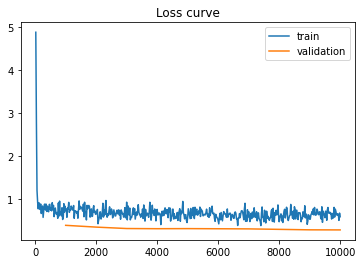

<Figure size 432x288 with 0 Axes>

In [27]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()
plt.savefig(outdir/"loss.png")

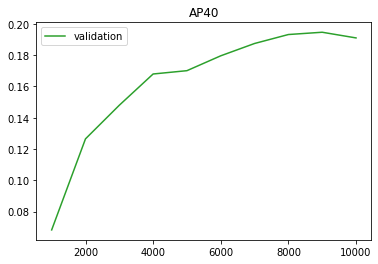

<Figure size 432x288 with 0 Axes>

In [28]:
fig, ax = plt.subplots()
mdf3 = mdf[~mdf["bbox/AP75"].isna()]
ax.plot(mdf3["iteration"], mdf3["bbox/AP75"] / 100., c="C2", label="validation")

ax.legend()
ax.set_title("AP40")
plt.show()
plt.savefig(outdir / "AP40.png")

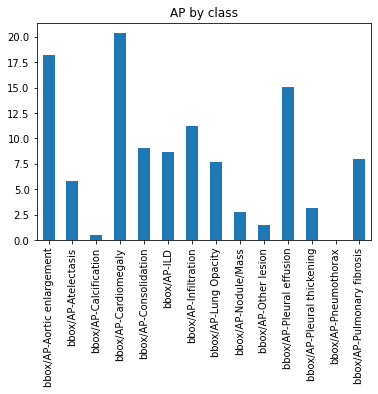

In [29]:
fig, ax = plt.subplots()
mdf_bbox_class = mdf3.iloc[-1][[f"bbox/AP-{col}" for col in thing_classes]]
mdf_bbox_class.plot(kind="bar", ax=ax)
_ = ax.set_title("AP by class")

Our Evaluator calculaes AP by class, and it is easy to check which class is diffucult to train.

In my experiment, **"Calcification" seems to be the most difficult class to predict**.

<a id="vis_aug"></a>
# Visualization of augmentation by Mapper

Let's check the behavior of Mapper method. Since mapper is used inside DataLoader, we can check its behavior by constucting DataLoader and visualize the data processed by the DataLoader.

The defined Trainer class has **class method** `build_train_loader`. We can construct train_loader purely from `cfg`, without instantiating `trainer` since it's class method.

Below code is to visualize the same data 4 times. You can check that augmentation is applied and every time the image looks different.

Note that both `detectron2.data.transforms` & `albumentations` augmentations properly handles bounding box. Thus bounding box is adjusted when the image is scaled, rotated etc!

At first I was using `detectron2.data.transforms` with `MyMapper` class, it provides basic augmentations.<br/>
Then I noticed that we can use many augmentations in `albumentations`, so I implemented `AlbumentationsMapper` to support it.<br/>
How many augmentations can be used in albumentations?<br/>
You can see official github page, all [Pixel-level transforms](https://github.com/albumentations-team/albumentations#pixel-level-transforms) and [Spatial-level transforms](https://github.com/albumentations-team/albumentations#spatial-level-transforms) with "BBoxes" checked can be used. There are really many!!!

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
[05/24 20:18:25 d2.data.build]: Removed 8505 images with no usable annotations. 3495 images left.
[05/24 20:18:25 d2.data.common]: Serializing 3495 elements to byte tensors and concatenating them all ...
[05/24 20:18:25 d2.data.common]: 

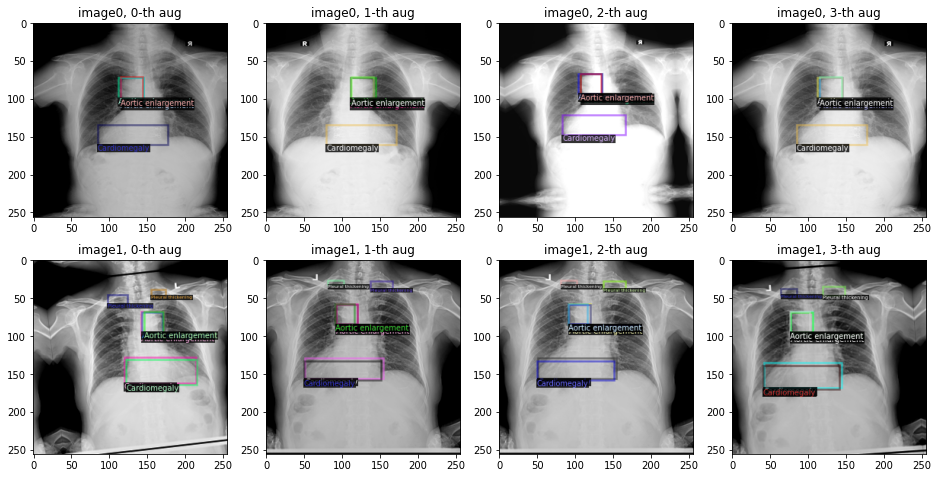

In [30]:
# Visualize data...
# import matplotlib.pyplot as plt
from detectron2.data.samplers import TrainingSampler

n_images = 2
n_aug = 4

fig, axes = plt.subplots(n_images, n_aug, figsize=(16, 8))

# Ref https://github.com/facebookresearch/detectron2/blob/22b70a8078eb09da38d0fefa130d0f537562bebc/tools/visualize_data.py#L79-L88
for i in range(n_aug):
    sampler = TrainingSampler(len(dataset_dicts), shuffle=False)
    train_vis_loader = MyTrainer.build_train_loader(
        cfg, sampler=sampler
    )  # For visualization...
    for batch in train_vis_loader:
        for j, per_image in enumerate(batch):
            ax = axes[j, i]

            img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))
            visualizer = Visualizer(
                img_arr[:, :, ::-1], metadata=vinbigdata_metadata, scale=1.0
            )
            target_fields = per_image["instances"].get_fields()
            labels = [
                vinbigdata_metadata.thing_classes[i] for i in target_fields["gt_classes"]
            ]
            out = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            # out = visualizer.draw_dataset_dict(per_image)

            img = out.get_image()[:, :, ::-1]
            filepath = str(outdir / f"vinbigdata_{j}_aug{i}.jpg")
            cv2.imwrite(filepath, img)
            print(f"Visualization img {img_arr.shape} saved in {filepath}")
            ax.imshow(img)
            ax.set_title(f"image{j}, {i}-th aug")
        break

That's all! 

I found that the competition data is not so many (15000 for all images, 4000 images after filtering "No finding" images).<br/>
It does not take long time to train (less than a day), so this competition may be a good choice for beginners who want to learn object detection!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated 😁<br>Thanks!</h3>

<a id="next_step"></a>
# Next step

[📸VinBigData detectron2 prediction](https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction) kernel explains how to use trained model for the prediction and submisssion for this competition.

[📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline) kernel explains how to train 2 class classifier model for the prediction and submisssion for this competition.

## Discussions
These discussions are useful to further utilize this training notebook to conduct deeper experiment.

 - [1-step training & prediction](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/219672): The 1-step pipeline which does not use any 2-class classifier approach is proposed.
 - [What anchor size & aspect ratio should be used?](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/220295): Suggests how to predict more smaller sized, high aspect ratio bonding boxes. It affects to the score a lot!!!
 - [Preferable radiologist's id in the test dataset?](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/219221): Investigation of test dataset annotation distribution.


In [33]:
# TODO:
# visualize predicted lesions with radiologist input
# visualize XAI to discover what model had learnt


In [ ]:
n_images = 2
n_aug = 4

fig, axes = plt.subplots(n_images, n_aug, figsize=(16, 8))

# Ref https://github.com/facebookresearch/detectron2/blob/22b70a8078eb09da38d0fefa130d0f537562bebc/tools/visualize_data.py#L79-L88
for i in range(n_aug):
    sampler = TrainingSampler(len(dataset_dicts), shuffle=False)
    train_vis_loader = MyTrainer.build_train_loader(
        cfg, sampler=sampler
    )  # For visualization...
    for batch in train_vis_loader:
        for j, per_image in enumerate(batch):
            ax = axes[j, i]

            img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))
            visualizer = Visualizer(
                img_arr[:, :, ::-1], metadata=vinbigdata_metadata, scale=1.0
            )
            target_fields = per_image["instances"].get_fields()
            labels = [
                vinbigdata_metadata.thing_classes[i] for i in target_fields["gt_classes"]
            ]
            out = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            # out = visualizer.draw_dataset_dict(per_image)

            img = out.get_image()[:, :, ::-1]
            filepath = str(outdir / f"vinbigdata_{j}_aug{i}.jpg")
            cv2.imwrite(filepath, img)
            print(f"Visualization img {img_arr.shape} saved in {filepath}")
            ax.imshow(img)
            ax.set_title(f"image{j}, {i}-th aug")
        break